torch.Size([10000, 2]) torch.Size([10000])
tensor([[ -3.1987,   7.3945],
        [ -9.0976, -10.2246],
        [  5.5605,   2.5364],
        [ -8.1341,  -9.6798],
        [ -5.8277,  -5.7955]]) tensor([0, 2, 1, 2, 2])


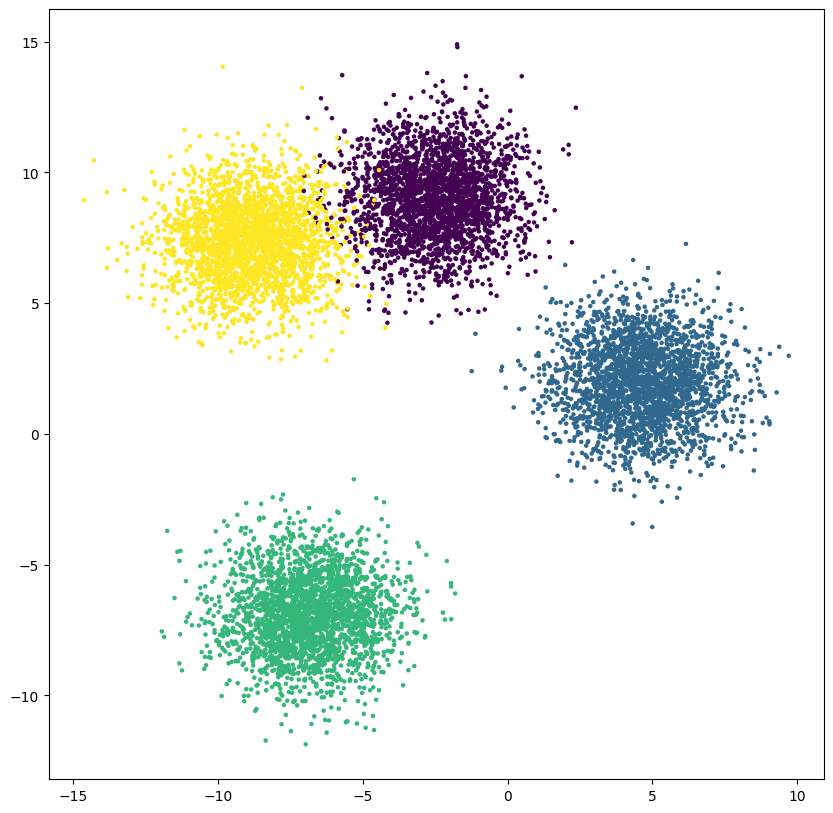

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_STATE = 42
NUM_SAMPLES = 10000

X_blob, y_blob = make_blobs(
    n_samples=NUM_SAMPLES,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    random_state=RANDOM_STATE,
    cluster_std=1.5
)

X_blob = torch.from_numpy(X_blob).float()
y_blob = torch.from_numpy(y_blob).long()
print(X_blob.shape, y_blob.shape)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_STATE
)

plt.figure(figsize=(10, 10))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, s=5)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [25]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initializes all required hyperparameters for multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.

        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features),
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_features).

        """
        return self.linear_layer_stack(x)

model_4 = MLP(NUM_FEATURES, NUM_CLASSES)
model_4.to(device)

MLP(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [27]:
model_4(X_blob_train)[:5]

tensor([[-0.3599, -1.4971, -1.2670, -0.3718],
        [-0.2468, -1.2474, -1.0060, -0.2984],
        [-0.0986, -0.9505, -0.5882, -0.1269],
        [-0.1407, -1.0368, -0.7023, -0.1710],
        [ 0.2509, -0.2392,  0.1830, -0.0028]], grad_fn=<SliceBackward0>)

In [28]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred_probs[:5], y_logits[:5]

(tensor([[0.2830, 0.3983, 0.1051, 0.2137],
         [0.3016, 0.2863, 0.1623, 0.2498],
         [0.3073, 0.3198, 0.1520, 0.2208],
         [0.3031, 0.1767, 0.2578, 0.2624],
         [0.3435, 0.1279, 0.1815, 0.3472]], grad_fn=<SliceBackward0>),
 tensor([[-1.2548, -0.9130, -2.2454, -1.5358],
         [-0.6320, -0.6842, -1.2517, -0.8207],
         [-0.6838, -0.6438, -1.3876, -1.0143],
         [ 0.1771, -0.3625,  0.0150,  0.0327],
         [-0.2116, -1.1999, -0.8497, -0.2009]], grad_fn=<SliceBackward0>))

In [29]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [30]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2830, 0.3983, 0.1051, 0.2137], grad_fn=<SelectBackward0>)
tensor(1)


In [31]:
def accuracy_fn(y_pred_probs, y_true):
    """
    Calculates accuracy of model predictions.

    Args:
        y_pred_probs (torch.Tensor): Tensor of shape (batch_size, num_classes)
          with probabilities of each class.
        y_true (torch.Tensor): Tensor of shape (batch_size,) with true classes.

    Returns:
        float: Accuracy of model predictions.

    """
    y_pred = torch.argmax(y_pred_probs, dim=1)
    return torch.sum(y_pred == y_true).item() / len(y_true)

In [32]:
torch.manual_seed(RANDOM_STATE)

epochs = 1001

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)

    loss = loss_fn(y_pred_probs, y_blob_train)
    accuracy = accuracy_fn(y_pred_probs, y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_probs = torch.softmax(test_logits, dim=1)

        test_loss = loss_fn(test_probs, y_blob_test)
        test_accuracy = accuracy_fn(test_probs, y_blob_test)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: train loss {loss:.4f}, train accuracy {accuracy:.4f}, test loss {test_loss:.4f}, test accuracy {test_accuracy:.4f}")
        

Epoch 0: train loss 1.3238, train accuracy 0.3805, test loss 1.3138, test accuracy 0.4530


Epoch 100: train loss 0.7897, train accuracy 0.9896, test loss 0.7893, test accuracy 0.9870
Epoch 200: train loss 0.7609, train accuracy 0.9905, test loss 0.7639, test accuracy 0.9870
Epoch 300: train loss 0.7579, train accuracy 0.9906, test loss 0.7612, test accuracy 0.9865
Epoch 400: train loss 0.7567, train accuracy 0.9908, test loss 0.7601, test accuracy 0.9865
Epoch 500: train loss 0.7559, train accuracy 0.9908, test loss 0.7595, test accuracy 0.9860
Epoch 600: train loss 0.7554, train accuracy 0.9909, test loss 0.7591, test accuracy 0.9860
Epoch 700: train loss 0.7551, train accuracy 0.9909, test loss 0.7588, test accuracy 0.9860
Epoch 800: train loss 0.7548, train accuracy 0.9909, test loss 0.7586, test accuracy 0.9860
Epoch 900: train loss 0.7546, train accuracy 0.9909, test loss 0.7584, test accuracy 0.9860
Epoch 1000: train loss 0.7544, train accuracy 0.9909, test loss 0.7583, test accuracy 0.9860


In [33]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logits[:10]

tensor([[ -4.5947,  17.3268, -13.8608, -16.5393],
        [ -3.1381,  10.6681,  -7.6861,  -9.5741],
        [ -2.4509,  11.1351,  -9.3310, -11.4596],
        [ -6.5636,  -6.9418,   4.6318,  -2.3004],
        [ -5.5175, -11.4827,  -6.7233,   7.8599],
        [ -4.2291,  16.0555, -12.8379, -15.3920],
        [ -1.6335,  -8.5021,  -6.5493,   3.4444],
        [ -2.2273,   8.9081,  -6.9749,  -8.8225],
        [ -3.9727,  14.7070, -11.5188, -13.9011],
        [ -3.6744,  13.8081, -10.8662, -13.1725]])

In [34]:
from helper_functions import plot_decision_boundary

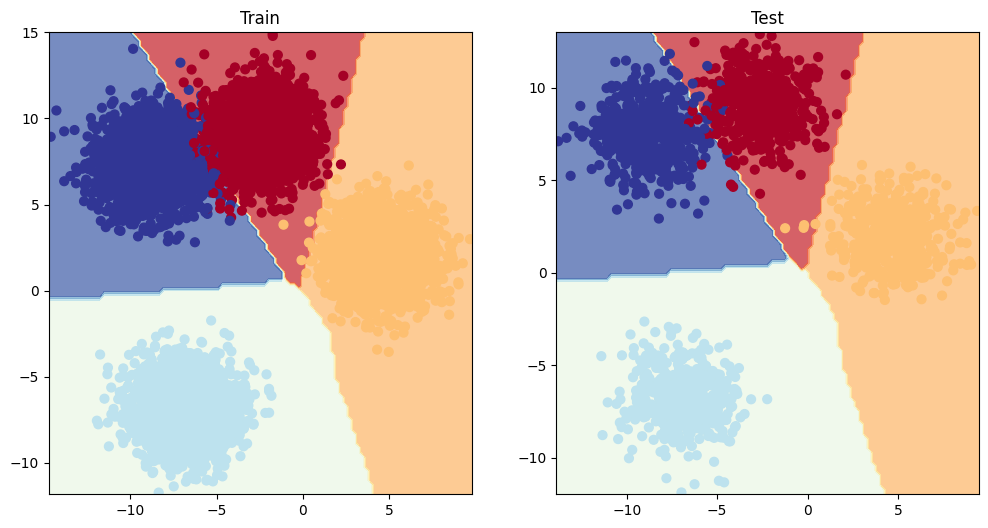

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)